# Выпускной проект:<br>**Телекоммуникации**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**<br>
Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.

- Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);

- Выделенная линия технической поддержки (`TechSupport`);

- Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);

- Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

## Подготовка

**Импорты:**

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from phik import phik_matrix
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from stringcase import snakecase
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

**Настройки:**

In [104]:
pd.set_option('display.max_colwidth', None)

**Константы:**

In [105]:
RANDOM_STATE = 20924
TEST_SIZE = 0.25

**Функции:**

In [106]:
def load_df(file_name: str) -> pd.DataFrame:

    """
    Функция загружает файл и выводит краткую информацию.
    """

    df = pd.read_csv(
        f"datasets/{file_name}",
        index_col=[0]
        )

    display(df.head())
    display(df.info())

    return df

In [107]:
def snake_case(df: pd.DataFrame) -> list:

    """ Функция создает список с названием столбцов DataFrame в snake_case. """

    return [snakecase(title) for title in df.columns]

In [108]:
def my_pie_plot(data: pd.DataFrame, column: str, figsize: tuple = (7, 7)) -> None:

    """
    Функция для отрисовки одного pieplot для конкретного
    признака переданного DataFrame.
    """

    data = data.groupby(by=column).size()
    plt.figure(figsize=figsize)
    plt.pie(data,
            autopct="%1.0f%%",
            labels=data.index,
            wedgeprops={'width': 0.2},
            colors=sns.color_palette("YlGnBu")[2:])
    plt.text(0, 0,
            column.replace("_", " ").title(),
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=14)

In [109]:
def my_pie_plots(df: pd.DataFrame, type: list = [object, bool]) -> None:

    """
    Функция для отрисовки нескольких pieplot графиков
    для признаков типа object переданного DataFrame.
    """

    df = pd.DataFrame(df)

    columns = []

    for column in df:
        if df[column].dtypes in type:
            columns.append(column)

    x = (len(columns) + 2) // 3
    fig, axs = plt.subplots(x, 3, figsize=(18, 6*x))

    for i in range(x):
        for j in range(3):
            coords = [(i, j), (j)][x == 1]
            try:
                col = columns.pop(0)
                data = df.groupby(by=col).size()
                axs[coords].pie(data,
                                autopct="%1.0f%%",
                                labels=data.index,
                                wedgeprops={'width': 0.3},
                                colors=sns.color_palette("YlGnBu")[1:],
                                )
                axs[coords].text(0, 0,
                                 col.replace("_", " ").title(),
                                 horizontalalignment='center',
                                 verticalalignment='center',
                                 fontsize=12)
            except:
                axs[coords].axis("off")

In [110]:
def my_hist_plot(df: pd.DataFrame,
                 column: str,
                 title: str = None,
                 bins: int = 30,
                 y_label: str = "Сумма") -> None:

    """
    Функция для отрисовки histplot, boxplot и вывода
    общей информации (describe()) для конкретного признака
    переданного DataFrame, на одном графике.
    """

    data = df[column]

    if title == None:
        title = (column.replace("_", " ")).title()

    fig, axs = plt.subplots(
        2, 2,
        figsize=(16, 5),
        gridspec_kw={'height_ratios': [5, 1], 'width_ratios': [3, 1]}
        )

    axs[0, 0].hist(data, bins=bins, color=sns.color_palette('YlGnBu')[3])
    axs[0, 0].xaxis.set_visible(False)
    axs[0, 0].set_ylabel("Количество клиентов")
    axs[0, 0].set_title(title)


    description = data.describe().to_string()
    axs[0, 1].text(0.7, 0.5, description, fontsize=12, ha="right", va="center")
    axs[0, 1].axis("off")

    sns.boxplot(data, ax=axs[1, 0], orient="h", color=sns.color_palette('YlGnBu')[0])
    axs[1, 0].set_xlabel(y_label)
    axs[1, 0].yaxis.set_visible(False)

    axs[1, 1].axis("off")

    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

## Загрузка данных

### Загрузка

Данные состоят из нескольких файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

***Информация о договоре:***

**Описание данных:**

- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

**Загрузка и проверка:**

In [111]:
# Загрузка датафрейма и вывод краткой информации
contract_new_df = load_df("contract_new.csv")

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


None

**Вывод:**

Пропусков нет. Названия признаков стоит привести к snake_case. Также необходимо привести `BeginDate` и `EndDate` к типу данных datetime, а `TotalCharges` к типу данных float.

***Персональные данные клиента:***

**Описание данных:**

- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

In [112]:
# Загрузка датафрейма и вывод краткой информации
personal_new_df = load_df("personal_new.csv")

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

**Вывод:**

Пропусков нет. Названия признаков стоит привести к snake_case.

***Информация об интернет-услугах:***

**Описание данных:**

- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

In [113]:
# Загрузка датафрейма и вывод краткой информации
internet_new_df = load_df("internet_new.csv")

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

**Вывод:**

Пропусков нет. Названия признаков стоит привести к snake_case.

***Информация об услугах телефонии:***

**Описание данных:**

- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

In [114]:
# Загрузка датафрейма и вывод краткой информации
phone_new_df = load_df("phone_new.csv")

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

**Вывод:**

Пропусков нет. Названия признаков стоит привести к snake_case.

### Вывод

Были получены четыре файла с данными клиентов оператора связи «ТелеДом»: `contract_new.csv`, `personal_new.csv`, `internet_new.csv` и `phone_new.csv`. Названия признаков во всех датафреймах необходимо привести к общему стилю - snake_case. Признаки `BeginDate` и `EndDate`, датафрейма `contract_new_df`, необходимо привести к типу данных datetime, а `total_charges` к типу данных float. Первые два датафрейма, c информацией о договорах (`contract_new_df`) и с персональными данными клиентов (`personal_new_df`), имеют одинаковое количество записей - по 7043, что логично, так как на одну запись клиента должна приходиться одна запись договора. Датафреймы с информацией об интернет-услугах (`internet_new_df`) и об услугах телефонии (`phone_new_df`) имеют уже разное количество записей 5517 и 6361 соответственно, так как разные клиенты пользуются разными услугами. Большенство признаков в датафреймах являются бинарными (Yes/No, Male/Female и т.д.)

## Исследовательский анализ и предобработка данных

### Информация о договоре



**Обработка:**

In [115]:
# Переименование признаков
contract_new_df.columns = snake_case(contract_new_df)

In [116]:
# Приведение к нужному типу данных
contract_new_df["begin_date"] = pd.to_datetime(contract_new_df["begin_date"], format="%Y-%m-%d", errors="coerce")
contract_new_df["end_date"] = pd.to_datetime(contract_new_df["end_date"], format="%Y-%m-%d", errors="coerce")
contract_new_df["total_charges"] = pd.to_numeric(contract_new_df["total_charges"], errors="coerce")
display(contract_new_df.head())
contract_new_df.info()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60
9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 440.2+ KB


Признаки переименованы в соответствии со `snake_case`. Данные приведены к нужному типу. Признак `end_date` после обработки содержит около 85% пропусков (тип данных `NaT`), так как большенство полей содержали значение `No`. В признаке `total_charges`, образовалось 11 пропусков, после приведения к типу `float`, так как стояла настройка `errors="coerce"`, из-за чего не явные пропуски получили тип `NaN`.

In [117]:
mask = contract_new_df['total_charges'].isna()
contract_new_df[mask]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN


Все 11 договоров имеют дату начала действия 2020.02.01, что соответсвует дате выгрузки, значит пропуски можно заменить на 0.

In [118]:
contract_new_df["total_charges"] = contract_new_df["total_charges"].fillna(0)
contract_new_df[mask]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,0.0
3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,0.0
5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,0.0
4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,0.0
1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,0.0
7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,0.0
3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,0.0
2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,0.0
2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,0.0


In [119]:
contract_new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 698.2+ KB


In [120]:
# Проверка на дубликаты среди клиентов
contract_new_df.index.duplicated().sum()

0

Среди клиентов дубликатов нет.

**Анализ категориальных признаков:**

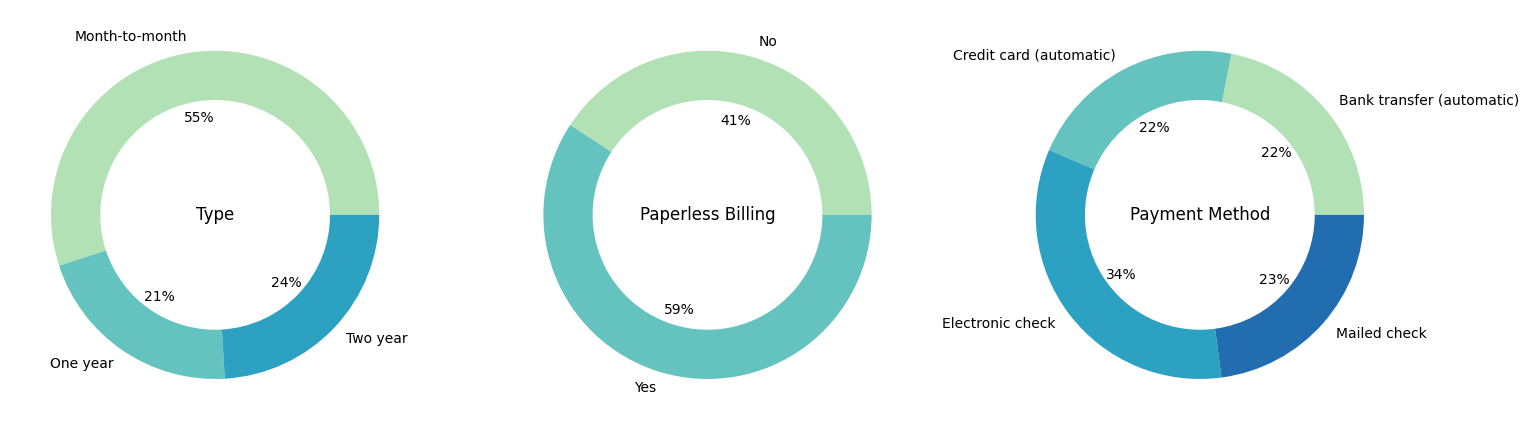

In [121]:
my_pie_plots(contract_new_df)

- 55% клиентов оплачивают услуги раз в месяц, 24% два раза в год и 21% раз в год, тоесть 45% клиентов точно являются постоянными и оформляют подписку на длительный срок;
- 59% клиентов используют бумажне расчетные листы, 41% - электронные;
- 34% клиентов оплачивают с помощью электронного чека, 23% с чека по почте, по 22% автоматически кредитными картами или банковским трансфером.

Неявных дубликатов и случайных значений, в признаках типа object, не обнаружено.

**Анализ числовых признаков:**

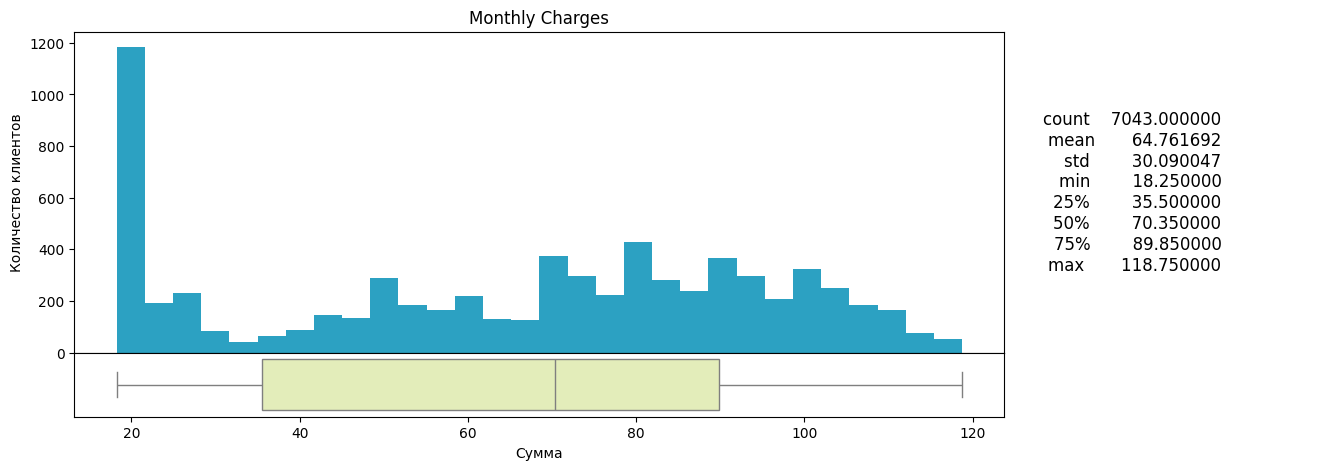

In [122]:
my_hist_plot(contract_new_df, "monthly_charges")

Большая часть клиентов, ежемесячно платит за услуги от 35 до 70 у.е. в месяц, в среднем 64. Однако наблюдается большой пик, около 1200 клиентов, которые платят меньше всех, около 20 у.е. в месяц, возможно - это те клиенты, которые пользуются только одной услугой, например - телефонная связь.  

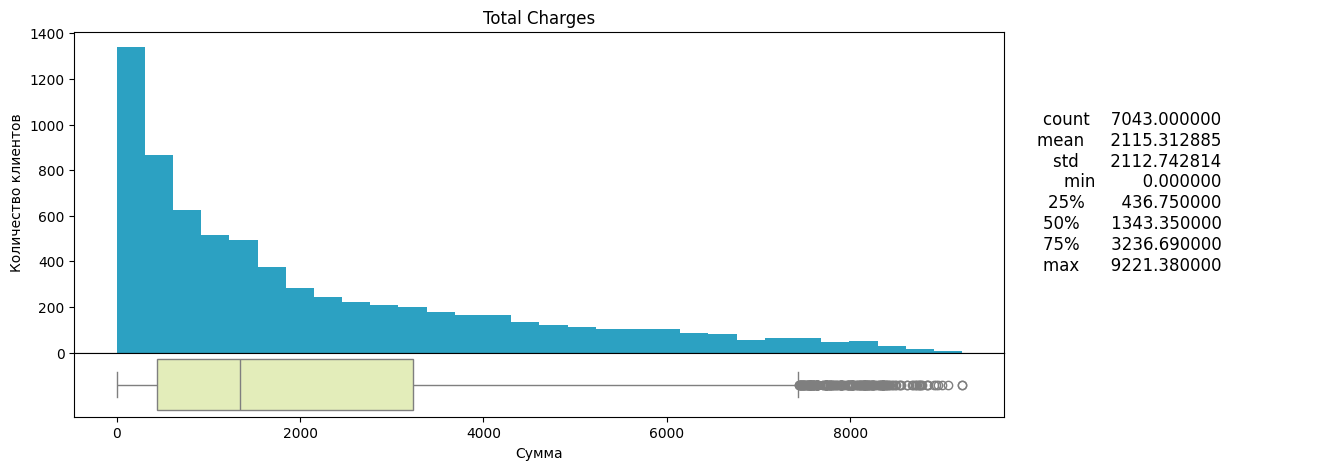

In [123]:
my_hist_plot(contract_new_df, "total_charges")

Распределение смещено вправо. Большенство клиентов потратили за все время от 500 до 3500 у.е., в среднем 2118. Также наблюдается большой пик в 1400 клиентов которые потратили меньше 400 у.е. за все время. Это может быть обусловленно большим притоком новых клиентов, которые еще не успели потратить много денег. На графике видны выбросы до 9200 у.е.

**Анализ временных признаков:**

In [124]:
# Подготовка данных для анализа дат
begin_date = contract_new_df.groupby("begin_date").size()
end_date = contract_new_df.groupby("end_date").size()

C:\Users\kapit\AppData\Local\Temp\ipykernel_10628\2631862746.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  y = begin_date.resample('1Y').sum()
C:\Users\kapit\AppData\Local\Temp\ipykernel_10628\2631862746.py:11: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  y = end_date.resample('1Y').sum()


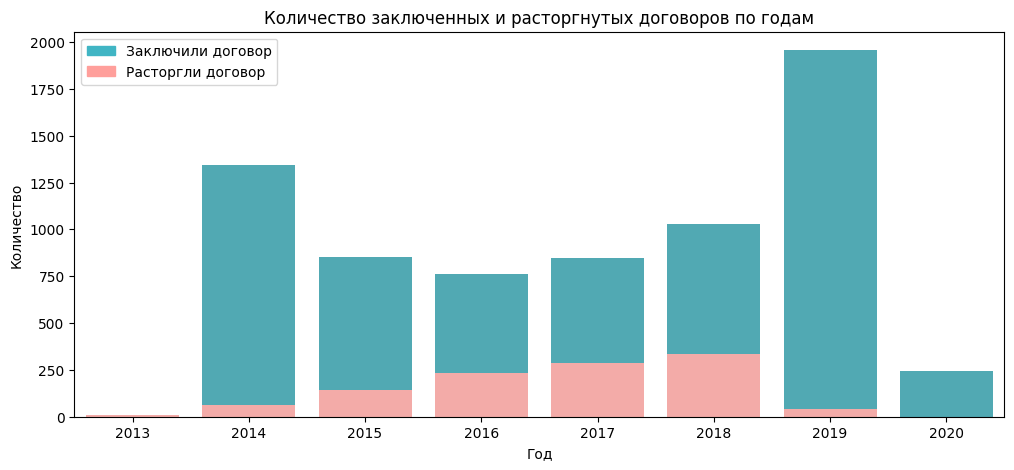

In [125]:
a_color = sns.color_palette("YlGnBu", 5)[2]
b_color = sns.color_palette("pastel", 5)[3]

plt.figure(figsize=(12, 5))

y = begin_date.resample('1Y').sum()
x = y.index.year

sns.barplot(y=y, x=x, color=a_color)

y = end_date.resample('1Y').sum()
y['2013-12-31'] = 0
sns.barplot(y=y, x=x, color=b_color)

plt.xlabel("Год")
plt.ylabel("Количество")
plt.title("Количество заключенных и расторгнутых договоров по годам")

a_color_patch = mpatches.Patch(color=a_color, label="Заключили договор")
b_color_patch = mpatches.Patch(color=b_color, label="Расторгли договор")

plt.legend(handles=[a_color_patch, b_color_patch], loc='upper left')
plt.show()

Больше всего было заключено договоров в 2020 году, около 2000, что в 2 раза больше чем в предыдущем 2019 году. меньше всего в 2016 - около 750 (за исключением не полного 2013 и 2020 года). Также много договоров было заключено в 2014 году. Количество окончаний срока договоров растет равномерно на 50-100 в год, не зависимо от количества заключенний.

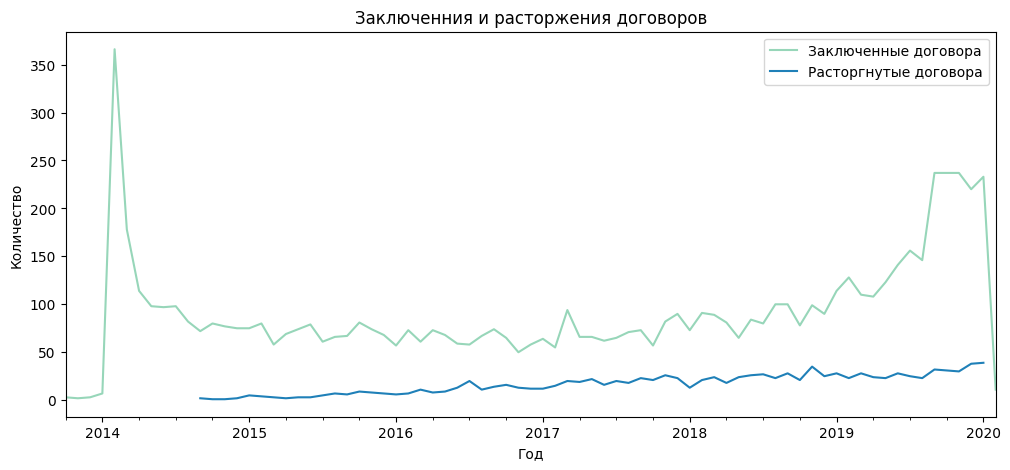

In [126]:
pd.DataFrame({
    'Заключенные договора': begin_date,
    'Расторгнутые договора': end_date
    }).plot(figsize=(12, 5), color=sns.color_palette('YlGnBu', n_colors=2))
plt.xlabel("Год")
plt.ylabel("Количество")
plt.title("Заключенния и расторжения договоров")
plt.show()

Большое число заключенных договоров в 2014 году, обусловленно тем, что судя по всему - это был первый год работы организации и работа начиналась с заранее подготовленной клиентской базой. Расторжение договоров происходит равномерно, без заметных пиков.

In [127]:
begin_date.head(10)

begin_date
2013-10-01      3
2013-11-01      2
2013-12-01      3
2014-01-01      7
2014-02-01    366
2014-03-01    178
2014-04-01    114
2014-05-01     98
2014-06-01     97
2014-07-01     98
dtype: int64

Первые семь месяцев являются выбросами, для анализа сезонности и тренда их лучше проигнорировать.

In [128]:
# Подготовка данных для анализа тренда и сезонности
decomposed_begin_date = seasonal_decompose(begin_date['2014-05-01':].resample('1M').sum())
decomposed_end_date = seasonal_decompose(end_date.resample('1M').sum())

C:\Users\kapit\AppData\Local\Temp\ipykernel_10628\115571034.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  decomposed_begin_date = seasonal_decompose(begin_date['2014-05-01':].resample('1M').sum())
C:\Users\kapit\AppData\Local\Temp\ipykernel_10628\115571034.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  decomposed_end_date = seasonal_decompose(end_date.resample('1M').sum())


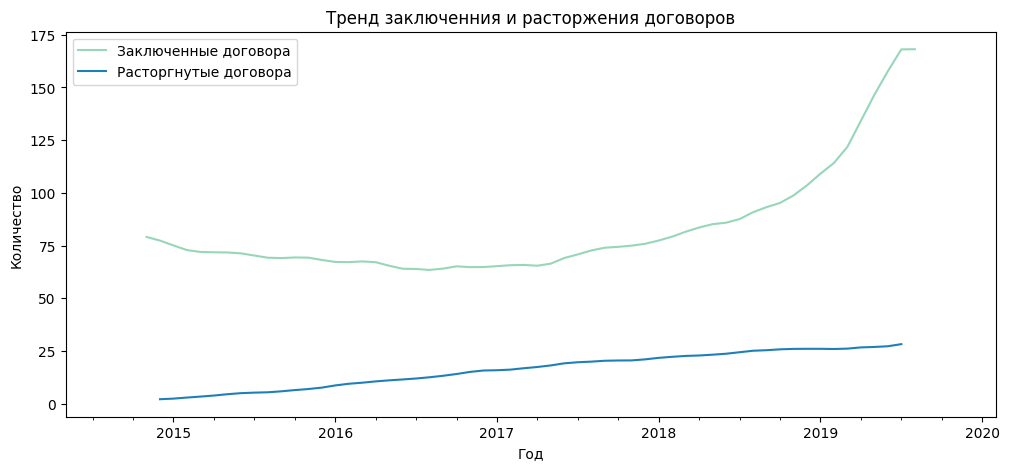

In [129]:
pd.DataFrame({
    'Заключенные договора': decomposed_begin_date.trend,
    'Расторгнутые договора': decomposed_end_date.trend
    }).plot(figsize=(12, 5), color=sns.color_palette('YlGnBu', n_colors=2))
plt.xlabel("Год")
plt.ylabel("Количество")
plt.title("Тренд заключенния и расторжения договоров")
plt.show()

Первый год работы организации естественно наблюдался рост количества заключенных договоров. Однако с 2015 по 2017 год их количество постепенно падало, но с 2018 начался уверенный рост, который по состоянию на 2020 год, продолжается. По расторгнутым договорам рост линейный.

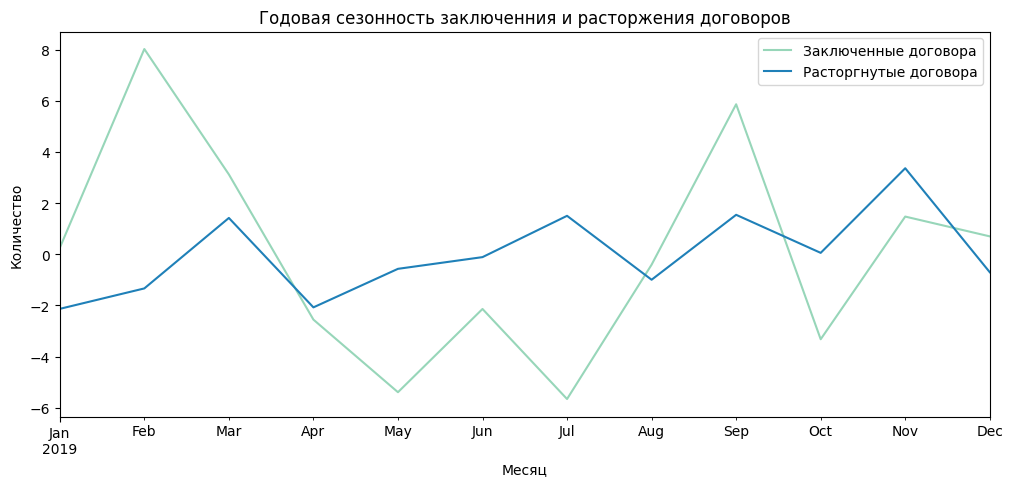

In [130]:
pd.DataFrame({
    'Заключенные договора': decomposed_begin_date.seasonal['2019-01-01':'2019-12-31'],
    'Расторгнутые договора': decomposed_end_date.seasonal['2019-01-01':'2019-12-31']
    }).plot(figsize=(12, 5), color=sns.color_palette('YlGnBu', n_colors=2))
plt.xlabel("Месяц")
plt.ylabel("Количество")
plt.title("Годовая сезонность заключенния и расторжения договоров")
plt.show()

На годовой сезонности пик заключенния новых договоров приходится на февраль, к лету количество новых договоров падает до минимума в июле, к началу осени опять растет с пиком в сентябре, к середине осени падает и вновь растет до февраля. Среди расторжений нет какой-то ярко выраженной сезонности, в среднем чаще всего рассторжения приходятся на ноябрь, также часто рассторгают договор летом, когда меньше всего регестрируется новых договоров.

In [131]:
# Подготовка данных для анализа дат
data = contract_new_df.groupby("end_date").size()
resemp_data = data.resample('1Y').sum()
decomposed_data = seasonal_decompose(resemp_data)

C:\Users\kapit\AppData\Local\Temp\ipykernel_10628\469857846.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  resemp_data = data.resample('1Y').sum()


### Персональные данные клиента


**Обработка:**

In [132]:
# Переименование столбцов
personal_new_df.columns = snake_case(personal_new_df)

In [133]:
personal_new_df["senior_citizen"].value_counts()

senior_citizen
0    5901
1    1142
Name: count, dtype: int64

Признак `senior_citizen` бинарный, можно привести его к общему виду всех бинарных признаков в датафреймах (Yes/No):

In [134]:
personal_new_df["senior_citizen"] = personal_new_df["senior_citizen"].apply(
    lambda x: ["No", "Yes"][x == 1]
)

In [135]:
personal_new_df["senior_citizen"].value_counts()

senior_citizen
No     5901
Yes    1142
Name: count, dtype: int64

In [136]:
display(personal_new_df.head())
personal_new_df.info()

,gender,senior_citizen,partner,dependents
customerID,,,,
7590-VHVEG,Female,No,Yes,No
5575-GNVDE,Male,No,No,No
3668-QPYBK,Male,No,No,No
7795-CFOCW,Male,No,No,No
9237-HQITU,Female,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          7043 non-null   object
 1   senior_citizen  7043 non-null   object
 2   partner         7043 non-null   object
 3   dependents      7043 non-null   object
dtypes: object(4)
memory usage: 275.1+ KB


In [137]:
# Проверка на дубликаты среди клиентов
personal_new_df.index.duplicated().sum()

0

Признаки переименованы в соответствии со snake_case. Значения бинарного признака `senior_citizen` приведены к типу Yes/No. Среди клиентов дубликатов нет.

**Анализ:**

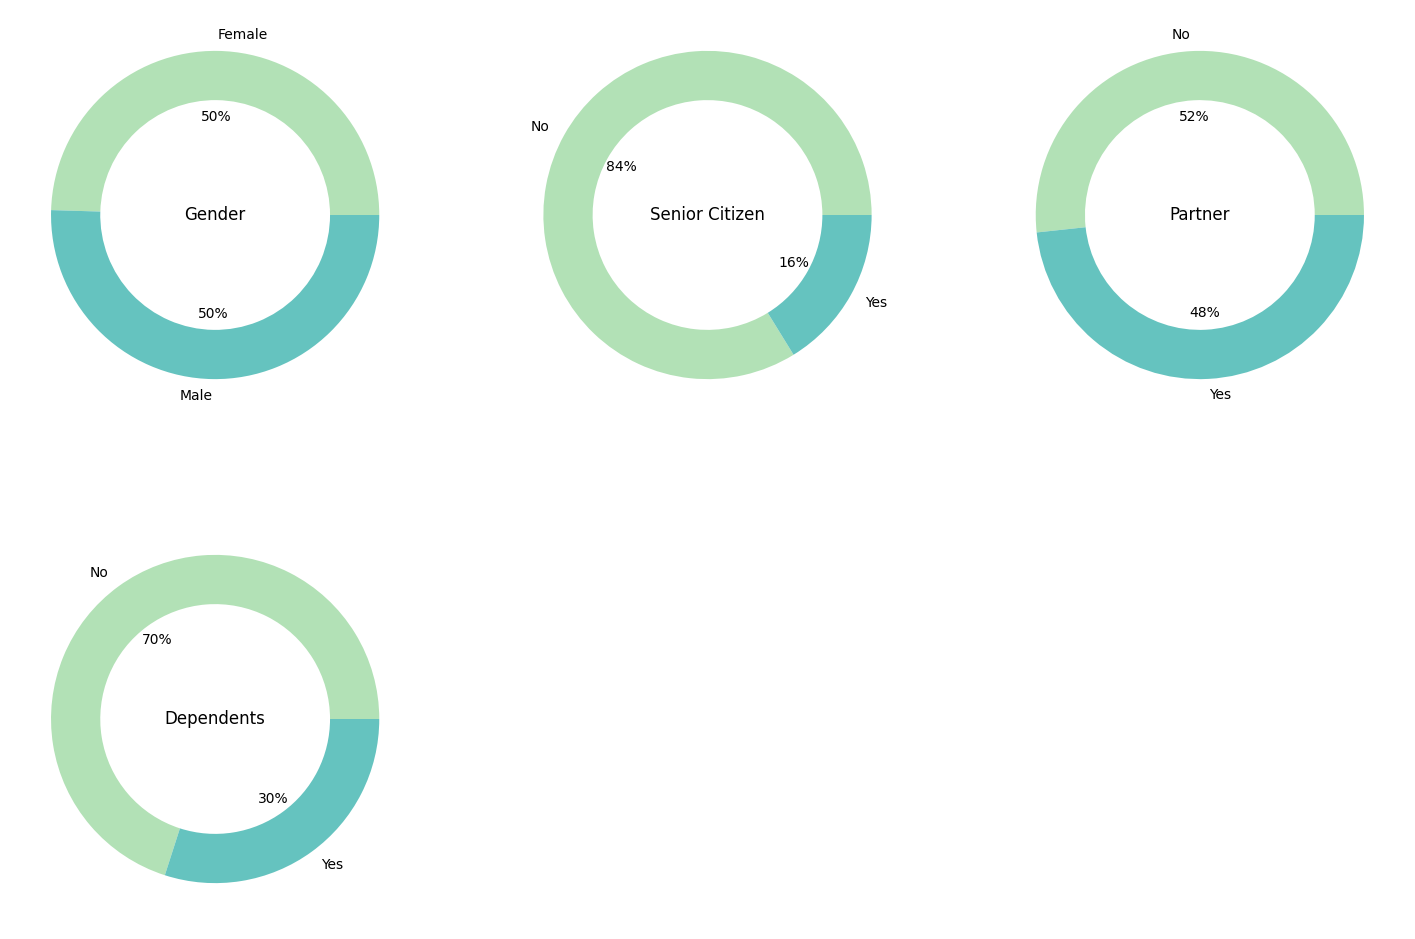

In [138]:
my_pie_plots(personal_new_df)

- Мужчины и женщины, среди клиентов, распределены поровну, по 50 %;
- Пенсионеров всего 16% от общего числа клиентов;
- Количество клиентов которые имеют или не имеют партнеров почти равно 48% и 52% соответсвенно;
- У 30% абонентов есть дети.

Неявных дубликатов и случайных значений в признаках не обнаружено.

### Информация об интернет-услугах

**Обработка:**

In [139]:
# Переименование столбцов
internet_new_df.columns = snake_case(internet_new_df)
internet_new_df.rename(columns={"streaming_t_v": "streaming_tv"}, inplace=True)
display(internet_new_df.head())
internet_new_df.info()

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   internet_service   5517 non-null   object
 1   online_security    5517 non-null   object
 2   online_backup      5517 non-null   object
 3   device_protection  5517 non-null   object
 4   tech_support       5517 non-null   object
 5   streaming_tv       5517 non-null   object
 6   streaming_movies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [140]:
# Проверка на дубликаты среди клиентов
internet_new_df.index.duplicated().sum()

0

Признаки переименованы в соответствии со snake_case. Среди клиентов дубликатов нет.

**Анализ:**

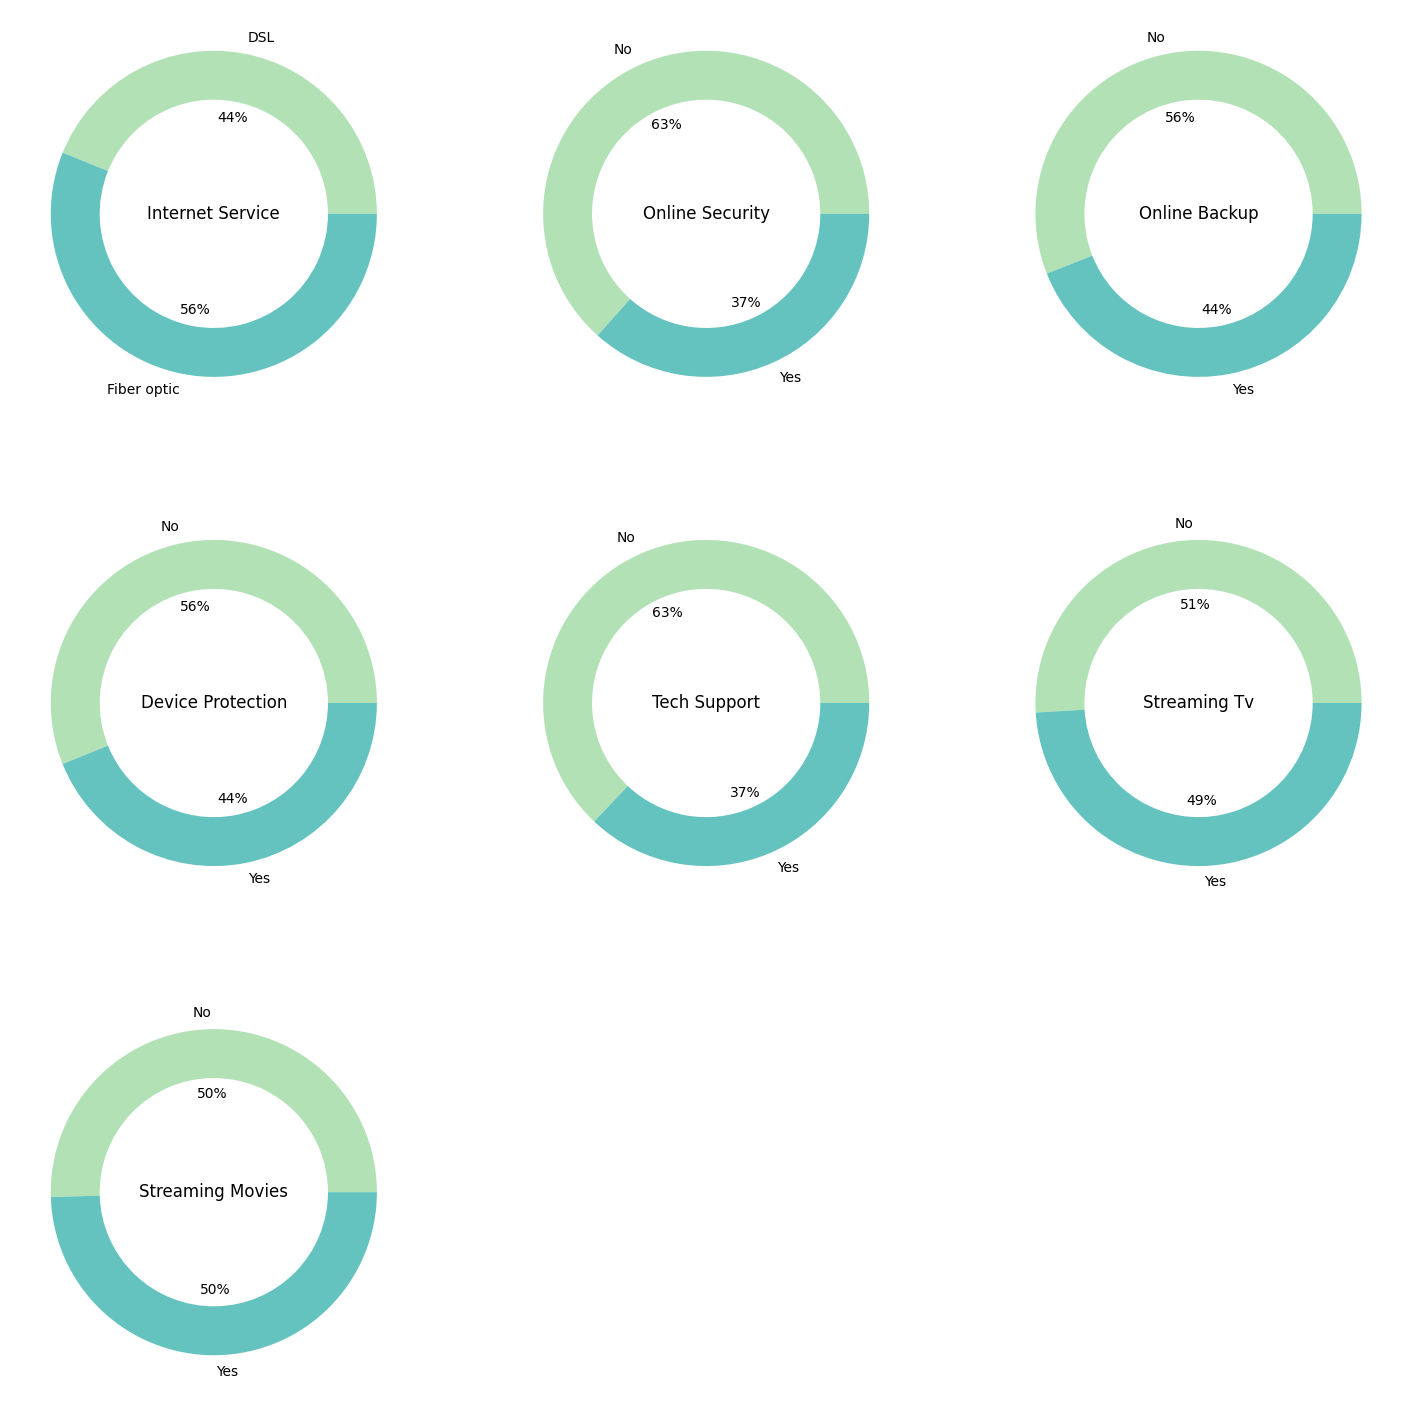

In [141]:
my_pie_plots(internet_new_df)

- 56% абонентов используют подключение через оптиволокно, а 44 телефонную линию (DSL);
- 36% абонентов пользуются услугой блокировки опасных сайтов;
- 44% используют облачное хранилище файлов для резервного копирования данных;
- 44% подключили антивирус;
- 37% подключили выделенную линию технической поддержки;
- 49% используют стриминговое телевидение;
- 50% пользователей подключили каталог фильмов.

Неявных дубликатов и случайных значений в признаках не обнаружено.

### Информация об услугах телефонии

**Обработка:**

In [142]:
# Переименование столбцов
phone_new_df.columns = snake_case(phone_new_df)
display(phone_new_df.head())
phone_new_df.info()

,multiple_lines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   multiple_lines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [143]:
# Проверка на дубликаты среди клиентов
phone_new_df.index.duplicated().sum()

0

Признаки переименованы в соответствии со snake_case. Среди клиентов дубликатов нет.

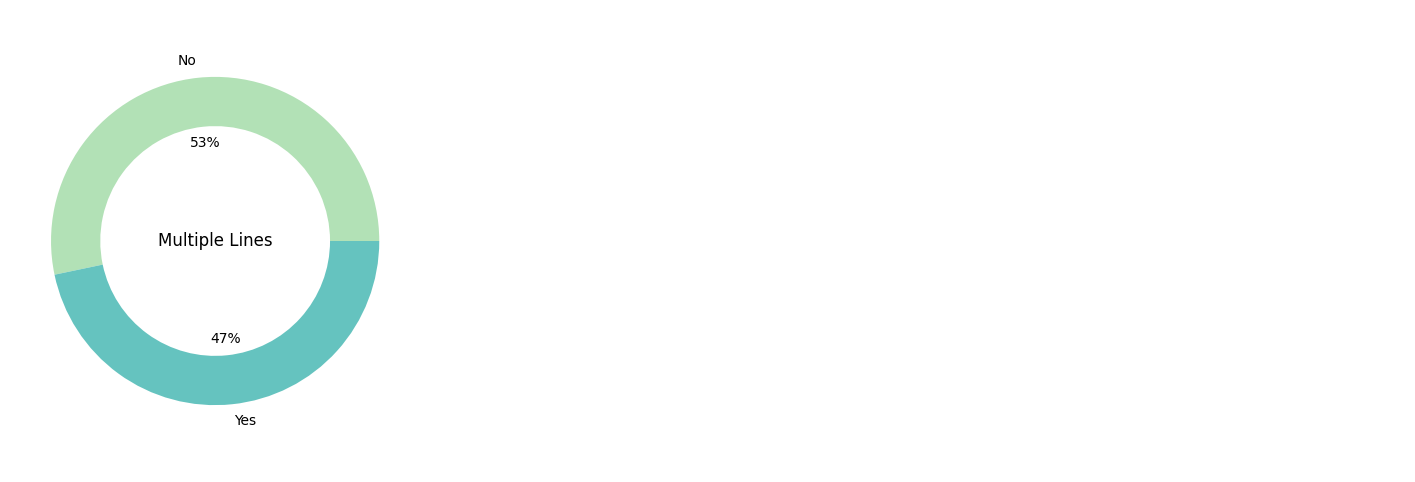

In [144]:
my_pie_plots(phone_new_df)

47% абонентов подключили телефон к нескольким линиям одновременно. Неявных дубликатов и случайных значений в признаках не обнаружено.

### Вывод

Названия признаков во всех датафреймах были приведены к общему стилю - snake_case. Признаки `begin_date` и `end_date`, датафрейма `contract_new_df`, были приведены к типу данных datetime, а `total_charges` к типу данных float. Признак `end_date` после обработки содержит около 85% пропусков (тип данных NaT), так как большенство полей содержали значение "No". Явные дубликаты в ID клиентов (`customerID`/index) не обнаружены ни в одном датафрейме.
Бинарный признак `senior_citizen`, датафрейма `personal_new_df`, был приведен к общему, для всех бинарных признаков в датафреймах, виду - *Yes/No*:
Cлучайных значений и неявных дубликатов, в категориальных признаках, не обнаружено.

- 55% клиентов оплачивают услуги раз в месяц, 24% два раза в год и 21% раз в год, тоесть 45% клиентов точно являются постоянными и оформляют подписку на длительный срок;
- 59% клиентов используют бумажне расчетные листы, 41% - электронные;
- 34% клиентов оплачивают с помощью электронного чека, 23% с чека по почте, по 22% автоматически кредитными картами или банковским трансфером;
- Мужчины и женщины, среди клиентов, распределены поровну, по 50 %;
- Пенсионеров всего 16% от общего числа клиентов;
- Количество клиентов которые имеют или не имеют партнеров почти равно 48% и 52% соответсвенно;
- У 30% абонентов есть дети;
- 56% абонентов используют подключение через оптиволокно, а 44 телефонную линию (DSL);
- 36% абонентов пользуются услугой блокировки опасных сайтов;
- 44% используют облачное хранилище файлов для резервного копирования данных;
- 44% подключили антивирус;
- 37% подключили выделенную линию технической поддержки;
- 49% используют стриминговое телевидение;
- 50% пользователей подключили каталог фильмов;
- 47% абонентов подключили телефон к нескольким линиям одновременно.


Большая часть клиентов, ежемесячно платит за услуги от 35 до 70 у.е. в месяц, в среднем 64. Однако наблюдается большая группа абонентов, около 1200, которые платят меньше всех, около 20 у.е. в месяц, возможно - это те клиенты, которые пользуются только одной услугой, например - телефонная связь. Основная масса клиентов потратила за все время от 500 до 3500 у.е., в среднем 2118 на абонента. Также имеется группа, 1400 абонентов, которые потратили меньше 400 у.е. за все время. Это может быть обусловленно большим притоком новых клиентов, которые еще не успели потратить много денег. Также имеются немогочисленные клиены потратившие за все время больше 8000 у.е.

Больше всего было заключено договоров в 2020 году, около 2000, что в 2 раза больше чем в предыдущем 2019 году. меньше всего в 2016 - около 750. Также много договоров было заключено в 2014 году. Большое число заключенных договоров в 2014 году, обусловленно тем, что судя по всему - это был первый год работы организации и работа начиналась с заранее подготовленной клиентской базой. Расторжение договоров происходит равномерно, без заметных пиков. Количество расторжений договоров растет равномерно на 50-100 в год, не зависимо от количества заключенний.

Первый год работы организации естественно наблюдался рост количества заключенных договоров. Однако с 2015 по 2017 год их количество постепенно падало, но с 2018 начался уверенный рост, который по состоянию на 2020 год, продолжается. По расторгнутым договорам рост линейный.

На годовой сезонности пик заключенния новых договоров приходится на февраль, к лету количество новых договоров падает до минимума в июле, к началу осени опять растет с пиком в сентябре, к середине осени падает и вновь растет до февраля. Среди расторжений нет какой-то ярко выраженной сезонности, в среднем чаще всего рассторжения приходятся на ноябрь, также часто рассторгают договор летом, когда меньше всего регестрируется новых договоров. В целом летом наблюдается самая низкая активность, много расторжений и мало заключений договоров.


## Объединение данных

### Объединение

In [145]:
# Объединение датафреймов
row_data = (
    contract_new_df.
    join(personal_new_df).
    join(internet_new_df).
    join(phone_new_df)
    )

display(row_data.head())
row_data.info()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

In [146]:
# Размер нового датафрейма
row_data.shape

(7043, 19)

### Вывод

Датафреймы `contract_new_df`, `personal_new_df`, `internet_new_df` и `phone_new_df` были объединены в общий датафрейм `data` по индексу `customerID`. Рамер получившегося датафрейма составляет 7043 на 19.	  

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Предобработка объединённого датафрейма и генерация новых признаков

In [147]:
data = row_data.copy(deep=True)

In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

На основе `end_date` и `begin_date` создадим признак продолжительности договора - `contract_duration`.

In [149]:
data["contract_duration"] = (
    data["end_date"].fillna(pd.Timestamp("2020-02-01")) - data["begin_date"]
    ).dt.days

 На основе `end_date` создадим целевой признак `target`.

In [150]:
data["target"] = data["end_date"].apply(lambda x: [1, 0][pd.isna(x)])

Затем удалим `end_date` и `begin_date`.

In [151]:
data = data.drop(["begin_date", "end_date"], axis=1)

Все оставшиеся пропуски в датафрейме связаны с тем, что абоненты не пользуются какими либо услугами, поэтому их можно заменить на `Not Used`.

In [152]:
data = data.fillna("Not Used")

Также cоздадим признаки `internet_user` - пользователи интернета, `phone_user` - пользователи телефона и `full_user` - пользователи интернета и телефона.

In [153]:
data["internet_user"] = data["internet_service"] != "Not Used"
data["phone_user"] = data["multiple_lines"] != "Not Used"
data["full_user"] = data["internet_user"] & data["phone_user"]

Создадим признак `quantity_of_services` - количество услуг.

In [154]:
data["quantity_of_services"] = data[["internet_service",
                                     "online_security",
                                     "online_backup",
                                     "device_protection",
                                     "tech_support",
                                     "streaming_tv"]].apply(lambda x: x.eq("Yes").sum(), axis=1)

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  7043 non-null   object 
 1   paperless_billing     7043 non-null   object 
 2   payment_method        7043 non-null   object 
 3   monthly_charges       7043 non-null   float64
 4   total_charges         7043 non-null   float64
 5   gender                7043 non-null   object 
 6   senior_citizen        7043 non-null   object 
 7   partner               7043 non-null   object 
 8   dependents            7043 non-null   object 
 9   internet_service      7043 non-null   object 
 10  online_security       7043 non-null   object 
 11  online_backup         7043 non-null   object 
 12  device_protection     7043 non-null   object 
 13  tech_support          7043 non-null   object 
 14  streaming_tv          7043 non-null   object 
 15  streaming_m

### Исследовательский анализ объединённого датафрейма

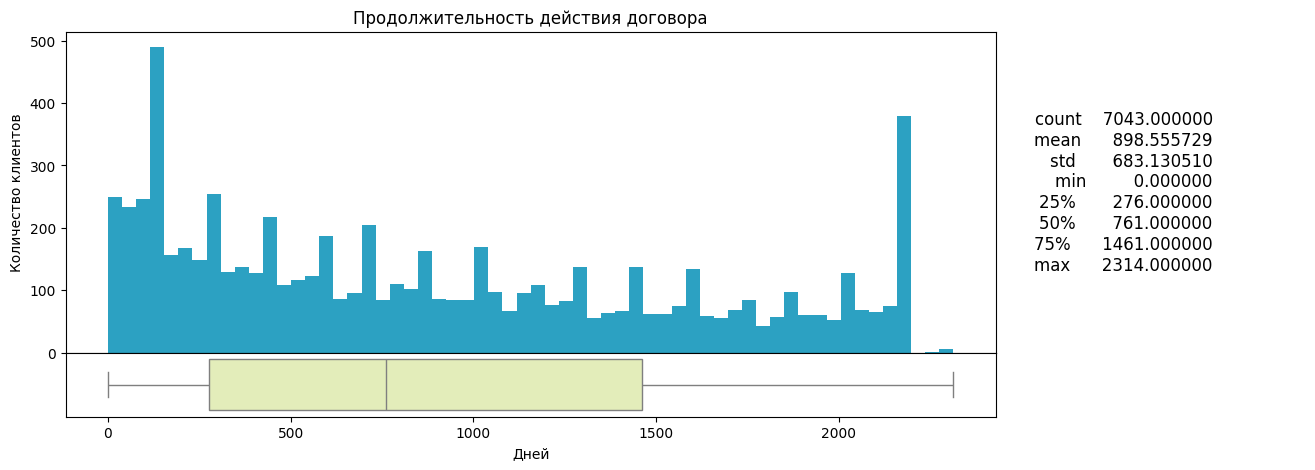

In [156]:
my_hist_plot(data,
             "contract_duration",
             bins=60,
             title="Продолжительность действия договора",
             y_label="Дней")

Наблюдается крупный пик "лояльных" абонентов, заключивших договор больше 2000 дней назад и большой пик из новых абонентов. Половина пользователей заключили договор от 1 года до 4 лет назад. Четверть абонентов заключила договор в течении последнего года. Оставшиеся четверть больше 4 лет назад. Приблизительно каждые пол года наблюдается всплеск роста заключенных договоров.

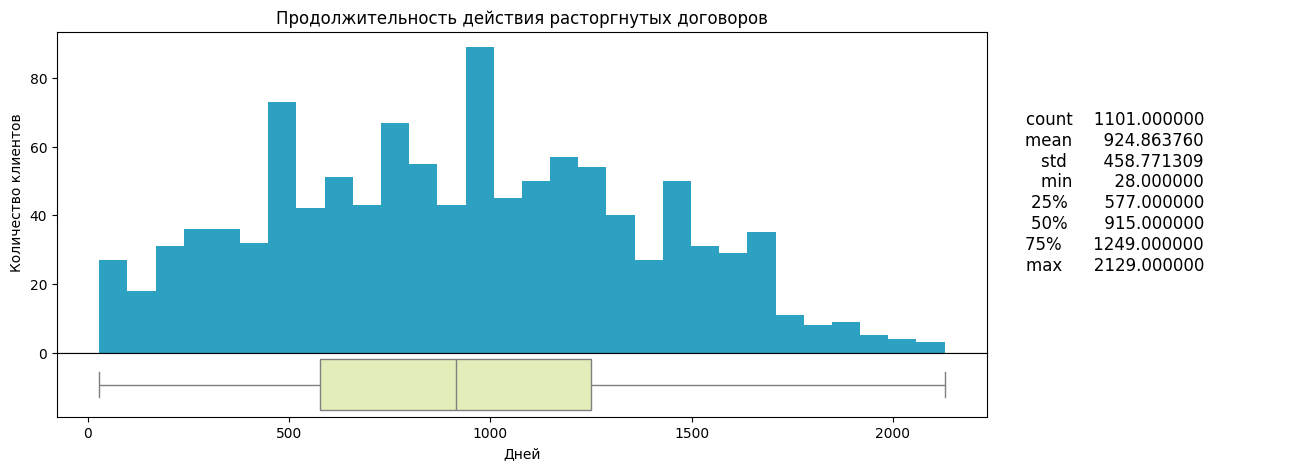

In [157]:
my_hist_plot(data.query("target == 1"),
             "contract_duration",
             bins=30,
             title="Продолжительность действия расторгнутых договоров",
             y_label="Дней")

Чаще всего абоненты расторгали контракт в период от 600 до 1200 дней после его подписания, в среднем через 924 дня. Примерно каждые 1,5 года у абонентов наблюдается всплеск расторжения договоров.

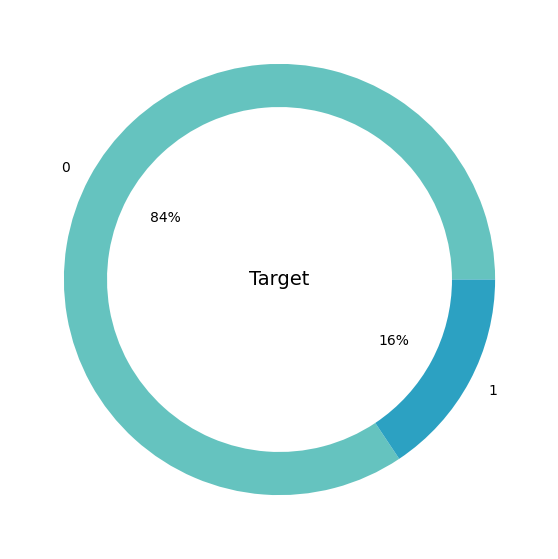

In [158]:
my_pie_plot(data, "target")

Из всех абонентов, 16% расторгли договор, за всё время.

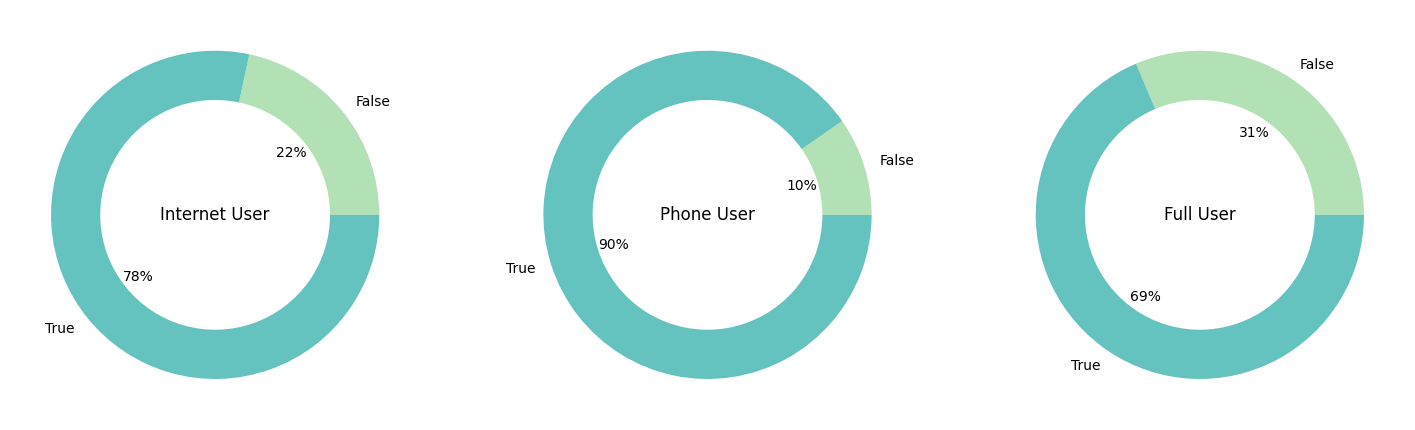

In [159]:
my_pie_plots(data[["internet_user", "phone_user", "full_user"]])

78% ипользуют интернет, 90% используют телефон, 69% используют и телефон и интернет.

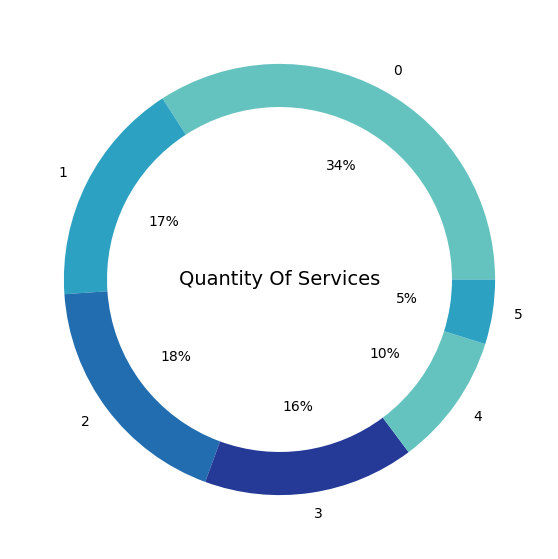

In [160]:
my_pie_plot(data, "quantity_of_services")

34% клиентов не используют дополнитиельные услуги. 18% используют две услуги, 17% - одну услугу, 16% - три, 10% - четыре и 5% используют пять услуг. Нет ни одного абонента кто подключил бы все шесть услуг одновременно.

### Корреляционный анализ объединённого датафрейма

In [161]:
matrix = data.phik_matrix(interval_cols=["monthly_charges", "total_charges", "contract_duration"])

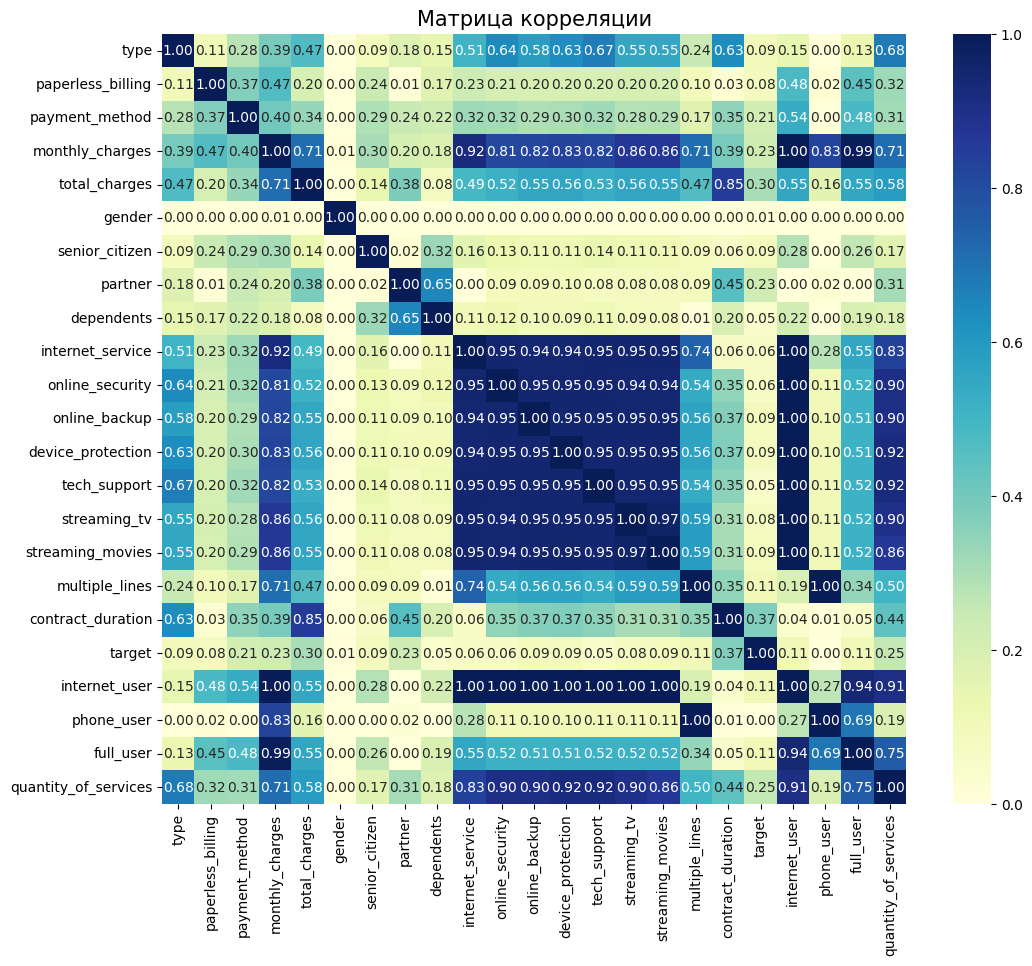

In [162]:
plt.figure(figsize=(12,10), dpi=100)
sns.heatmap(
    matrix,
    annot = True,
    fmt=".2f",
    cmap="YlGnBu"
)
plt.title('Матрица корреляции', fontdict = {'fontsize': 15})
plt.show()

На матрице корреляции четко видна область из признаков интернет услуг, которые сильно коррелируют между собой, - это вызвано тем, что при объединении датафреймов получившиеся пропуски в этих бинарных признаках были заполнены значением `Not Used` из-за чего эти признаки "обособились" от остальных. Также они логично имеют 100 процентную корреляцию с признаком `internet_user` и 90 процентную корреляцию с признаком `quantity_of_services`. С целевым признаком корреляция очень слабая, в районе 0.05 - 0.1. Признак `monthly_charges` имеет полную корреляцию с признаком `internrt_user` и почти полную с `full_user`, также слабую корреляцию - 0.23 с целевым признаком.

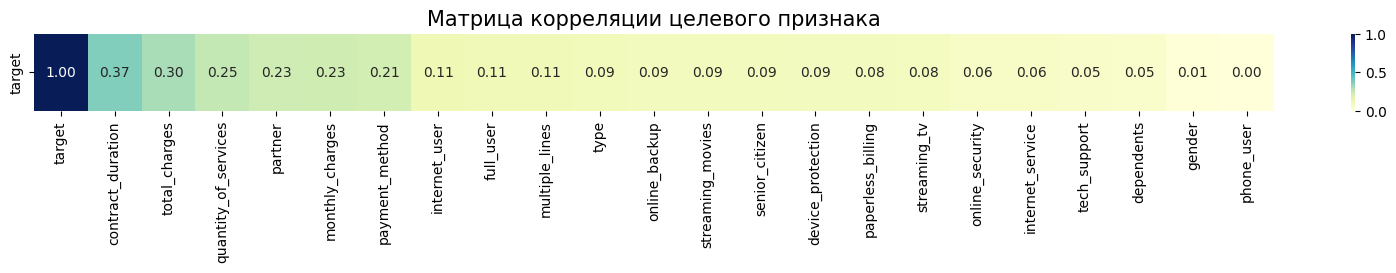

In [163]:
plt.figure(figsize=(20, 1), dpi=100)
sns.heatmap(pd.DataFrame(matrix.loc["target"].sort_values(ascending=False)).T,
    annot = True,
    fmt=".2f",
    cmap="YlGnBu"
)
plt.title('Матрица корреляции целевого признака', fontdict = {'fontsize': 15})
plt.show()

С целевым признаком `target` лучше всего коррелирует признак продолжительности контракта, `contract_duration` - 0.37. Затем идут признаки `total_charges`,
`quantity_of_services`, `partner`, `monthly_charges` и `payment_method`, с корреляцией от 0.21 до 0.30. Остальные признаки коррелируют не заметно. Для модели возьмем все признаки с корреляцией выше 0.20.

In [164]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  7043 non-null   object 
 1   paperless_billing     7043 non-null   object 
 2   payment_method        7043 non-null   object 
 3   monthly_charges       7043 non-null   float64
 4   total_charges         7043 non-null   float64
 5   gender                7043 non-null   object 
 6   senior_citizen        7043 non-null   object 
 7   partner               7043 non-null   object 
 8   dependents            7043 non-null   object 
 9   internet_service      7043 non-null   object 
 10  online_security       7043 non-null   object 
 11  online_backup         7043 non-null   object 
 12  device_protection     7043 non-null   object 
 13  tech_support          7043 non-null   object 
 14  streaming_tv          7043 non-null   object 
 15  streaming_m

In [165]:
# Создание итогового датафрейма для обучения
res_data = data[["target",
                 "contract_duration",
                 "total_charges",
                 "quantity_of_services",
                 "partner",
                 "monthly_charges",
                 "payment_method"]]

display(res_data.head())
res_data.info()

,target,contract_duration,total_charges,quantity_of_services,partner,monthly_charges,payment_method
customerID,,,,,,,
7590-VHVEG,0,31,31.04,1,Yes,29.85,Electronic check
5575-GNVDE,0,1036,2071.84,2,No,56.95,Mailed check
3668-QPYBK,0,123,226.17,2,No,53.85,Mailed check
7795-CFOCW,0,1371,1960.60,3,No,42.30,Bank transfer (automatic)
9237-HQITU,0,153,353.50,0,No,70.70,Electronic check


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   target                7043 non-null   int64  
 1   contract_duration     7043 non-null   int64  
 2   total_charges         7043 non-null   float64
 3   quantity_of_services  7043 non-null   int64  
 4   partner               7043 non-null   object 
 5   monthly_charges       7043 non-null   float64
 6   payment_method        7043 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 698.2+ KB


In [166]:
res_matrix = res_data.phik_matrix(interval_cols=["monthly_charges", "total_charges", "contract_duration"])

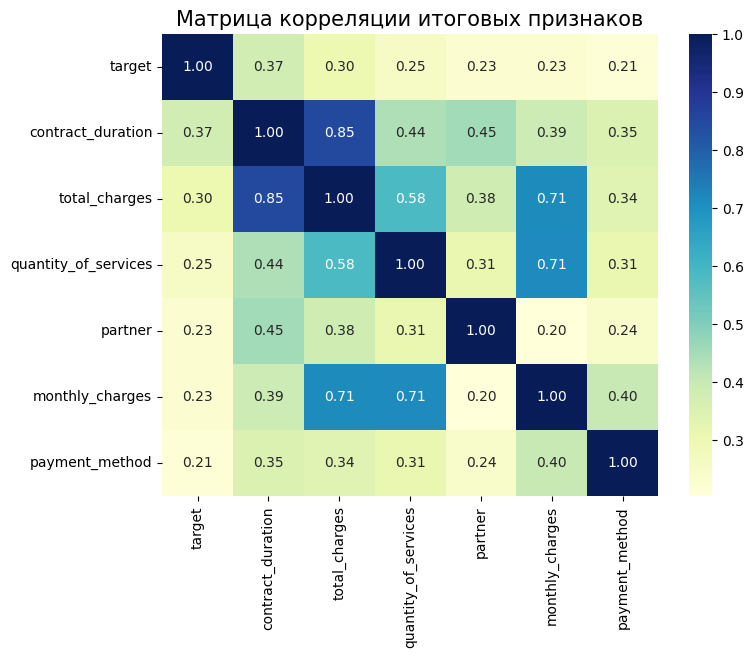

In [167]:
plt.figure(figsize=(8,6), dpi=100)
sns.heatmap(
    res_matrix,
    annot = True,
    fmt=".2f",
    cmap="YlGnBu"
)
plt.title('Матрица корреляции итоговых признаков', fontdict = {'fontsize': 15})
plt.show()

Среди итоговых признаков мультиколлинеарности не наблюдается, хорошо между собой коррелируют продолжительность договора `contract_duration` и общие расходы абонента `total_charges` - 0.85. А так-же расходы за месяц `monthly_charges` с общими расходами абонента `total_charges` и количеством сервисов `quantity_of_services` по 0.71.

### Вывод

Были созданы новые признаки:
- `target` - целевой признак (абоненты разорвавшие договор);
- `contract_duration` - продолжительность договора;
- `internet_user` - пользователи интернета;
- `phone_user` - пользователи телефона;
- `full_user` - пользователи и интернета и телефона;
- `quantity_of_services` - количество услуг.

Были удалены признаки `end_date` и `begin_date`, на основе которых были созданы `target` и `contract_duration`.

Все пропуски в датафрейме связаны с тем, что абоненты не пользуются какими либо услугами, поэтому они были заменены на `Not Used`.

По итогу анализа новых признаков выявлено:
- Половина пользователей заключили договор от 1 года до 4 лет назад. Четверть абонентов заключила договор в течении последнего года. Оставшиеся четверть больше 4 лет назад. Приблизительно каждые пол года наблюдается всплеск роста заключенных договоров;
- Чаще всего абоненты расторгали договор в период от 600 до 1200 дней после его подписания, в среднем через 924 дня. Примерно каждые 1,5 года у абонентов наблюдается всплеск расторжения договоров;
- 16% абонентов расторгли договор, за всё время;
- 78% ипользуют интернет;
- 90% используют телефон;
- 69% используют и телефон и интернет;
- 34% клиентов не используют дополнитиельные услуги. 18% используют две услуги, 17% - одну услугу, 16% - три. Нет ни одного абонента кто подключил бы все шесть услуг одновременно.

С целевым признаком `target` лучше всего коррелирует признак продолжительности контракта, `contract_duration` - 0.37. Затем идут признаки `total_charges`,
`quantity_of_services`, `partner`, `monthly_charges` и `payment_method`, с корреляцией от 0.21 до 0.30. Для модели были взяты признаки с корреляцией выше 0.20. Среди итоговых признаков мультиколлинеарности не наблюдается, хорошо между собой коррелируют продолжительность договора `contract_duration` и общие расходы абонента `total_charges` - 0.85. А так-же расходы за месяц `monthly_charges` с общими расходами абонента `total_charges` и количеством сервисов `quantity_of_services` по 0.71.



## Подготовка данных

### Разделение на выборки

Целевой признак `target` - бинарный, состоящий из `0` и `1`, его кодировать для задачи классификации не нужно, признак `quantity_of_services` содержит целые числа от `0` до `5` - количество используемых услуг. Это упорядоченные числа имеющие иерархию, тоже не теребуют дополнительных преобразований. Признаки `partner` и `payment_method` - категориальные, для работы с `CatBoost` необходимо задать им тип данных `category`. `contract_duration`, `total_charges` и `monthly_charges` - числовые, преобразования типа данных не требуют.

In [168]:
# Разделение датасета на обучающие и целевой признаки
X = res_data.drop("target", axis=1)
y = res_data["target"]

In [169]:
# Списки с наименованиями кодируемых признаков
ohe_col = ["partner", "payment_method"]
num_col = ["contract_duration", "total_charges", "monthly_charges"]

In [170]:
# Преобразование типа данных в категориальных признаках
X[ohe_col] = X[ohe_col].astype("category")

In [171]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   contract_duration     7043 non-null   int64   
 1   total_charges         7043 non-null   float64 
 2   quantity_of_services  7043 non-null   int64   
 3   partner               7043 non-null   category
 4   monthly_charges       7043 non-null   float64 
 5   payment_method        7043 non-null   category
dtypes: category(2), float64(2), int64(2)
memory usage: 547.2+ KB


In [172]:
# Разделение на тренировочные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

### Вывод

Для корректной работы с CatBoost был задан тип данных `category` для `partner` и `payment_method`. Выборки были разделены на тренировочную и тестовую с `test_size` в `0.25`.

## Обучение моделей машинного обучения

### Создание пайплайна

In [173]:
# Пайплайн для OneHotEncoder кодирования
ohe_pipe = Pipeline([
    ("ohe_encoder", OneHotEncoder(drop="first", handle_unknown="error"))
])

# Общий пайплайн для кодирования всех признаков
data_preprocessor = ColumnTransformer([
    ('ohe', "passthrough", ohe_col),
    ('num', "passthrough", num_col)
],
    remainder="passthrough"
)

pipe_final = Pipeline(
    [
        ("preprocessor", data_preprocessor),
        ("models", LogisticRegression(random_state=RANDOM_STATE))
    ]
)

### Обучение LogisticRegression

In [174]:
param_grid_lr = [
    {
        "models__C": range(1, 10),
        "models__max_iter": range(100, 1000, 100),
        "preprocessor__ohe": [ohe_pipe],
        "preprocessor__num": [StandardScaler()]
    }
]

randomized_search_lr = RandomizedSearchCV(
    pipe_final,
    param_grid_lr,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [175]:
randomized_search_lr.fit(X_train, y_train)
lr_cv_result = pd.DataFrame(randomized_search_lr.cv_results_).sort_values("rank_test_score")

print(f'Лучшая модель:, {randomized_search_lr.best_estimator_.named_steps["models"]}')
print(f'ROC-AUC лучшей модели на тренировочных данных:, {randomized_search_lr.best_score_}')
print(f'Среднее время обучения: {lr_cv_result["mean_fit_time"][0].round(3)} сек.')
print(f'Среднее время предсказания: {lr_cv_result["mean_score_time"][0].round(3)} сек.')

Лучшая модель:, LogisticRegression(C=4, max_iter=500, random_state=20924)
ROC-AUC лучшей модели на тренировочных данных:, 0.7131776682170224
Среднее время обучения: 0.015 сек.
Среднее время предсказания: 0.007 сек.


Метрика получилась слишком низкой - 0.71 (критерий успеха - 0.85).

### Обучение DecisionTreeClassifier

In [176]:
param_grid_tree = [
    {
        "models": [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        "models__max_depth": range(1, 10),
        "models__max_features": range(1, 10),
        "preprocessor__ohe": [ohe_pipe],
        "preprocessor__num": [StandardScaler()]
    }
]

randomized_search_tree = RandomizedSearchCV(
    pipe_final,
    param_grid_tree,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [177]:
randomized_search_tree.fit(X_train, y_train)

tree_cv_result = pd.DataFrame(randomized_search_tree.cv_results_).sort_values("rank_test_score")
print('Лучшая модель:', randomized_search_tree.best_estimator_.named_steps["models"])
print('ROC-AUC лучшей модели на тренировочных данных:', randomized_search_tree.best_score_)
print(f'Среднее время обучения: {tree_cv_result["mean_fit_time"][0].round(3)} сек.')
print(f'Среднее время предсказания: {tree_cv_result["mean_score_time"][0].round(3)} сек.')

Лучшая модель: DecisionTreeClassifier(max_depth=4, max_features=5, random_state=20924)
ROC-AUC лучшей модели на тренировочных данных: 0.7717328780975644
Среднее время обучения: 0.012 сек.
Среднее время предсказания: 0.007 сек.


Метрика всё еще низкая - 0.77.

### Обучение CatBoostClassifier

In [178]:
param_grid_catboost = [
    {
        "models": [CatBoostClassifier(random_state=RANDOM_STATE,
                                      cat_features=[0, 1],
                                      verbose=0)],
        "models__iterations": range(100, 900, 100),
        "models__depth": range(4, 12)
    }
]

randomized_search_catboost = RandomizedSearchCV(
    pipe_final,
    param_grid_catboost,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [179]:
randomized_search_catboost.fit(X_train, y_train)

catboost_cv_result = pd.DataFrame(randomized_search_catboost.cv_results_).sort_values("rank_test_score")
print('Лучшая модель:', randomized_search_catboost.best_params_)
print('ROC-AUC лучшей модели на тренировочных данных:', randomized_search_catboost.best_score_)
print(f'Среднее время обучения: {catboost_cv_result["mean_fit_time"][0].round(3)} сек.')
print(f'Среднее время предсказания: {catboost_cv_result["mean_score_time"][0].round(3)} сек.')

Лучшая модель: {'models__iterations': 400, 'models__depth': 6, 'models': <catboost.core.CatBoostClassifier object at 0x0000022133759150>}
ROC-AUC лучшей модели на тренировочных данных: 0.8633189536014956
Среднее время обучения: 30.214 сек.
Среднее время предсказания: 0.029 сек.


**Вывод:**

Метрика - 0.86, что намного больше предыдущих моделей и соответствует критерию успеха. Среднее время обучения заметно выше чем у остальных, а скорость предсказания почти ничем не отличается.

### Вывод

Результаты обучений трех моделей:
 - `LogisticRegression(C=4, max_iter=500, random_state=20924)`
 
    - метрика ROC-AUC: `0.713`.
    
    
 - `DecisionTreeClassifier(max_depth=4, max_features=5, random_state=20924)`
 
    - метрика ROC-AUC: `0.771`.
    
    
- `CatBoostClassifier(iterations=400, depth=6, random_state=20924)`

    - метрика ROC-AUC: `0.863`.

## Выбор лучшей модели

### Лучшая модель

`CatBoostClassifier(iterations=400, depth=6, random_state=20924)` - лучшая модель из трех обученных и единственная, соответствующая критерию ROC-AUC не меньше 0.85.

In [180]:
model = randomized_search_catboost

**Анализ влияния признаков с помощью SHAP:**

In [181]:
X_train_shap = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].fit_transform(X_train),
    columns=pipe_final.named_steps['preprocessor'].get_feature_names_out()
)
explainer = shap.Explainer(model.best_estimator_.named_steps["models"])
shap_values = explainer(X_train_shap)

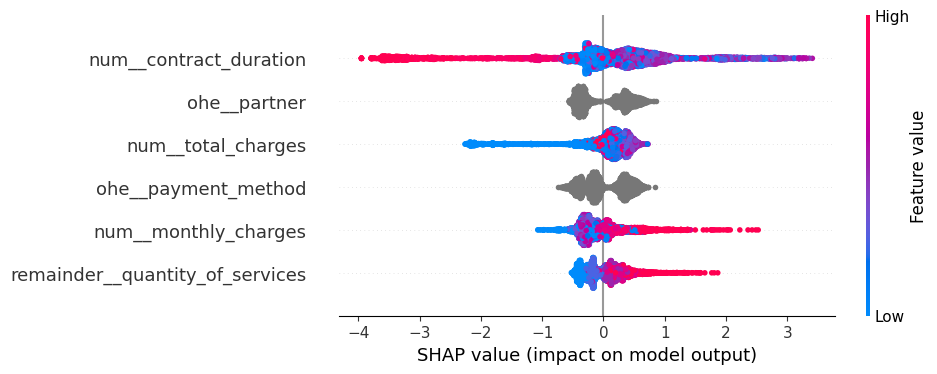

In [182]:
shap.plots.beeswarm(shap_values)

Самым влияющим признаком оказалась продолжительность договора, при ее увеличении модель склоняется к классу 0 - не разорвет договор. На втором месте признак общего количества потраченных денег, чем меньше сумма тем меньше модель склоняется к тому, что клиент уйдет. Также рост ежемесячной платы и количества используемых сервисов, склоняет модель к первому классу - абонент разорвет договор.

### Проверка качества на тестовой выборке

In [183]:
proba = model.predict_proba(X_test)
proba = proba[:, 1]

In [184]:
pred = model.predict(X_test)

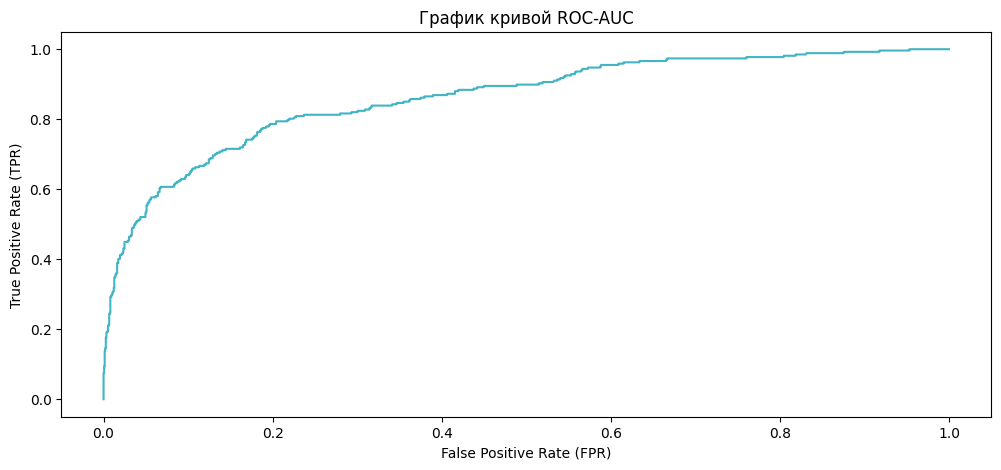

Метрика ROC-AUC: 0.861354281044277
Метрика accuracy: 0.8898353208404316


In [185]:
plt.figure(figsize=(12, 5))

fpr, tpr, threshold = roc_curve(y_test, proba)

plt.plot(fpr, tpr, color=sns.color_palette("YlGnBu", 5)[2])
plt.title("График кривой ROC-AUC")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

print('Метрика ROC-AUC:', roc_auc_score(y_test, proba))
print('Метрика accuracy:', accuracy_score(y_test, pred))

### Вывод

Была выбрана модель `CatBoostClassifier(iterations=400, depth=6, random_state=20924)` - так-как она единственная соответствовала критерию ROC-AUC не меньше 0.85.

Самый влияющий признак - продолжительность договора, при ее увеличении модель склоняется к классу 0. На втором месте признак общего количества потраченных денег, чем меньше сумма тем меньше модель склоняется к тому, что клиент уйдет. Также рост ежемесячной платы и количества используемых сервисов, склоняет модель к первому классу - абонент разорвет договор.

На тестовой выборке модель показала метрику ROC-AUC равную 0.86, а Accuracy равную 0.89.

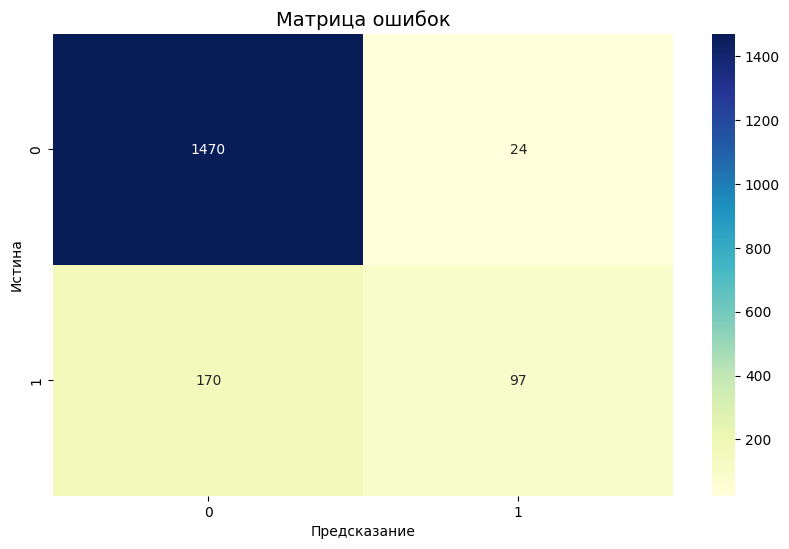

In [186]:
plt.figure(figsize=(10,6), dpi= 100)
sns.heatmap(confusion_matrix(y_test, pred), 
            annot = True, 
            fmt=".0f", 
            cmap='YlGnBu')

plt.ylabel('Истина')
plt.xlabel('Предсказание')
plt.title('Матрица ошибок',  fontdict = {'fontsize' : 14})
plt.show()

На матрице ошибок видно, что модель редко присваивает первый класс ошибочно, но часто ошибается, присваивая нулевой класс, «упуская» абонентов, желающих разорвать договор. Ситуацию можно поправить, в зависимости от предпочтений бизнеса, сдвинув порог присвоения класса, например, модель будет лучше предсказывать тех абонентов, кто готов разорвать договор, но чаще будет ошибочно относить к ним тех, кто не собирается отказываться от услуг компании.

In [187]:
# Порог
threshold = 0.3

In [188]:
threshold_pred = np.array(list(map(lambda x: int(x > threshold), proba)))

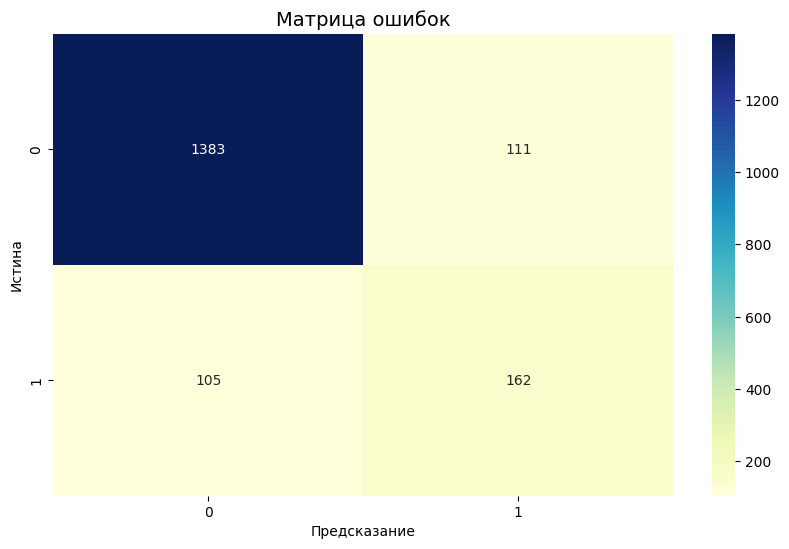

In [189]:
plt.figure(figsize=(10,6), dpi= 100)
sns.heatmap(confusion_matrix(y_test, threshold_pred), 
            annot = True, 
            fmt=".0f", 
            cmap='YlGnBu')

plt.ylabel('Истина')
plt.xlabel('Предсказание')
plt.title('Матрица ошибок',  fontdict = {'fontsize' : 14})
plt.show()

## Общий вывод и рекомендации заказчику

**Выводы:**

Были получены четыре файла с данными клиентов оператора связи «ТелеДом»: `contract_new.csv`, `personal_new.csv`, `internet_new.csv` и `phone_new.csv`.

Названия признаков во всех датафреймах были приведены к общему стилю - snake_case. Признаки `begin_date` и `end_date`, датафрейма `contract_new_df`, были приведены к типу данных `datetime`, а `total_charges` к типу данных `float`. Бинарный признак `senior_citizen`, датафрейма `personal_new_df`, был приведен к общему, для всех бинарных признаков в датафреймах, виду - *Yes/No*:
Cлучайных значений и неявных дубликатов, в категориальных признаках, не обнаружено.

В ходе анализа выявлено:
- 55% клиентов оплачивают услуги раз в месяц, 24% два раза в год и 21% раз в год, тоесть 45% клиентов точно являются постоянными и оформляют подписку на длительный срок;
- 59% клиентов используют бумажне расчетные листы, 41% - электронные;
- 34% клиентов оплачивают с помощью электронного чека, 23% с чека по почте, по 22% автоматически кредитными картами или банковским трансфером;
- Мужчины и женщины, среди клиентов, распределены поровну, по 50 %;
- Пенсионеров всего 16% от общего числа клиентов;
- Количество клиентов которые имеют или не имеют партнеров почти равно 48% и 52% соответсвенно;
- У 30% абонентов есть дети;
- 56% абонентов используют подключение через оптиволокно, а 44 телефонную линию (DSL);
- 36% абонентов пользуются услугой блокировки опасных сайтов;
- 44% используют облачное хранилище файлов для резервного копирования данных;
- 44% подключили антивирус;
- 37% подключили выделенную линию технической поддержки;
- 49% используют стриминговое телевидение;
- 50% пользователей подключили каталог фильмов;
- 47% абонентов подключили телефон к нескольким линиям одновременно.
- Половина пользователей заключили договор от 1 года до 4 лет назад. Четверть абонентов заключила договор в течении последнего года. Оставшиеся четверть больше 4 лет назад. Приблизительно каждые пол года наблюдается всплеск роста заключенных договоров;
- Чаще всего абоненты расторгали договор в период от 600 до 1200 дней после его подписания, в среднем через 924 дня. Примерно каждые 1,5 года у абонентов наблюдается всплеск расторжения договоров;
- 16% абонентов расторгли договор, за всё время;
- 78% ипользуют интернет;
- 90% используют телефон;
- 69% используют и телефон и интернет;
- 34% клиентов не используют дополнитиельные услуги. 18% используют две услуги, 17% - одну услугу, 16% - три. Нет ни одного абонента кто подключил бы все шесть услуг одновременно.

Большая часть клиентов, ежемесячно платит за услуги от 35 до 70 у.е. в месяц, в среднем 64. Однако наблюдается большая группа абонентов, около 1200, которые платят меньше всех, около 20 у.е. в месяц. Основная масса клиентов потратила за все время от 500 до 3500 у.е., в среднем 2118 на абонента. Также имеется группа, 1400 абонентов, которые потратили меньше 400 у.е. за все время и немогочисленные клиены потратившие за все время больше 8000 у.е.

Больше всего было заключено договоров в 2020 году, около 2000, что в 2 раза больше чем в предыдущем 2019 году. меньше всего в 2016 - около 750. Также много договоров было заключено в 2014 году. Большое число заключенных договоров в 2014 году, обусловленно тем, что судя по всему - это был первый год работы организации и работа начиналась с заранее подготовленной клиентской базой. Расторжение договоров происходит равномерно, без заметных пиков. Количество расторжений договоров растет равномерно на 50-100 в год, не зависимо от количества заключенний.

Первый год работы организации естественно наблюдался рост количества заключенных договоров. Однако с 2015 по 2017 год их количество постепенно падало, но с 2018 начался уверенный рост, который по состоянию на 2020 год, продолжается. По расторгнутым договорам рост линейный.

На годовой сезонности пик заключенния новых договоров приходится на февраль, к лету количество новых договоров падает до минимума в июле, к началу осени опять растет с пиком в сентябре, к середине осени падает и вновь растет до февраля. Среди расторжений нет какой-то ярко выраженной сезонности, в среднем чаще всего рассторжения приходятся на ноябрь, также часто рассторгают договор летом, когда меньше всего регестрируется новых договоров. В целом летом наблюдается самая низкая активность, много расторжений и мало заключений договоров.

Датафреймы `contract_new_df`, `personal_new_df`, `internet_new_df` и `phone_new_df` были объединены в общий датафрейм `data` по индексу `customerID`.

Были созданы новые признаки:
- `target` - целевой признак (абоненты разорвавшие договор);
- `contract_duration` - продолжительность договора;
- `internet_user` - пользователи интернета;
- `phone_user` - пользователи телефона;
- `full_user` - пользователи и интернета и телефона;
- `quantity_of_services` - количество услуг.

Были удалены признаки `end_date` и `begin_date`, на основе которых были созданы `target` и `contract_duration`.

С целевым признаком `target` лучше всего коррелирует признак продолжительности контракта, `contract_duration` - 0.37. Затем идут признаки `total_charges`,
`quantity_of_services`, `partner`, `monthly_charges` и `payment_method`, с корреляцией от 0.21 до 0.30. Для модели были взяты признаки с корреляцией выше 0.20.
Были обучены три модели:
Результаты обучений трех моделей:
 - `LogisticRegression(C=4, max_iter=500, random_state=20924)`
 
    - метрика ROC-AUC: `0.713`.
    
    
 - `DecisionTreeClassifier(max_depth=4, max_features=5, random_state=20924)`
 
    - метрика ROC-AUC: `0.771`.
    
    
- `CatBoostClassifier(iterations=400, depth=6, random_state=20924)`

    - метрика ROC-AUC: `0.863`.

Итоговой была выбрана модель `CatBoostClassifier(iterations=500, depth=7, random_state=20924)` - так-как она единственная соответствовала критерию ROC-AUC не меньше 0.85.

Самый влияющий признак итоговой модели - продолжительность договора, при ее увеличении модель склоняется к классу 0. На втором месте признак общего количества потраченных денег, чем меньше сумма тем меньше модель склоняется к тому, что клиент уйдет. Также рост ежемесячной платы и количества используемых сервисов, склоняет модель к первому классу - абонент разорвет договор.

На тестовой выборке модель показала метрику ROC-AUC равную 0.85, а Accuracy равную 0.88.


**Рекомендации:**

- Больше половины абонентов - 55%, оплачивют услуги раз в месяц, для большего их вовлечения, стоит увеличить долю тех кто платит раз в один-два года, возможно, стоит рассмотреть возможность предоставления скидки за оформление таких тарифов.
- Только 21% используют больше двух дополнительных услуг, стоит рассмотреть возможность объединения нескольких услуг в пакеты с небольшой скидкой.
- Каждые полтора года после заключения договора, наблюдается всплеск оттока клиентов, имеет смысл при приближении такого переода предлогать абонентам различные бонусы, будь то скидки или бесплатный доступ к некоторым услугам на определенный срок, что в свою очередь послужит рекламой для этих услуг.
- Около 59% абонентов используют бумажные чеки и около 56% оплачивают услуги вручную (не автоматически), стоит стимулировать клиентов переходить на автоматический способ оплаты и на электронные чеки, что сэкономит средства на доставке и печате квитанций и повысит удобство сервиса, а также сделает затраты клиента на пользование услугами менее заметными для него.
- DSL подключение является устаревшим для доступа к интернету, такой тип подключения используют около 44% абонентов, при том что интернетом пользуются 78% абонентов. Имеет смысл провести модернизацию сети, чтобы удержать клиентов, пользующихся интернетом, учитывая, что в последние пару лет наблюдается резкий рост числа абонентов.

